# Notebook 13: Using Deep Learning to Study SUSY with Pytorch

## Learning Goals
The goal of this notebook is to introduce the powerful PyTorch framework for building neural networks and use it to analyze the SUSY dataset. After this notebook, the reader should understand the mechanics of PyTorch and how to construct DNNs using this package. In addition, the reader is encouraged to explore the GPU backend available in Pytorch on this dataset.

## Overview
In this notebook, we use Deep Neural Networks to classify the supersymmetry dataset, first introduced by Baldi et al. in [Nature Communication (2015)](https://www.nature.com/articles/ncomms5308). The SUSY data set consists of 5,000,000 Monte-Carlo samples of supersymmetric and non-supersymmetric collisions with $18$ features. The signal process is the production of electrically-charged supersymmetric particles which decay to $W$ bosons and an electrically-neutral supersymmetric particle that is invisible to the detector.

The first $8$ features are "raw" kinematic features that can be directly measured from collisions. The final $10$ features are "hand constructed" features that have been chosen using physical knowledge and are known to be important in distinguishing supersymmetric and non-supersymmetric collision events. More specifically, they are given by the column names below.

In this notebook, we study this dataset using Pytorch.

In [65]:
from __future__ import print_function, division
import os,sys
import numpy as np
import torch # pytorch package, allows using GPUs
# fix seed
seed=17
np.random.seed(seed)
torch.manual_seed(seed)

## Structure of the Procedure

Constructing a Deep Neural Network to solve ML problems is a multiple-stage process. Quite generally, one can identify the key steps as follows:

* ***step 1:*** Load and process the data
* ***step 2:*** Define the model and its architecture
* ***step 3:*** Choose the optimizer and the cost function
* ***step 4:*** Train the model 
* ***step 5:*** Evaluate the model performance on the *unseen* test data
* ***step 6:*** Modify the hyperparameters to optimize performance for the specific data set

Below, we sometimes combine some of these steps together for convenience.

Notice that we take a rather different approach, compared to the simpler MNIST Keras notebook. We first define a set of classes and functions and run the actual computation only in the very end.

### Step 1: Load and Process the SUSY Dataset

The supersymmetry dataset can be downloaded from the UCI Machine Learning repository on [https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz](https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz). The dataset is quite large. Download the dataset and unzip it in a directory.

Loading data in Pytroch is done by creating a user-defined a class, which we name `SUSY_Dataset`, and is a child of the `torch.utils.data.Dataset` class. This ensures that all necessary attributes required for the processing of the data during the training and test stages are easily inherited. The `__init__` method of our custom data class should contain the usual code for loading the data, which is problem-specific, and has been discussed for the SUSY data set in Notebook 5. More importantly, the user-defined data class must override the `__len__` and `__getitem__` methods of the parent `DataSet` class. The former returns the size of the data set, while the latter allows the user to access a particular data point from the set by specifying its index.

In [66]:
from torchvision import datasets # load data

class SUSY_Dataset(torch.utils.data.Dataset):
    """SUSY pytorch dataset."""

    def __init__(self, data_file, root_dir, dataset_size, train=True, transform=None, high_level_feats=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            train (bool, optional): If set to `True` load training data.
            transform (callable, optional): Optional transform to be applied on a sample.
            high_level_festures (bool, optional): If set to `True`, working with high-level features only. 
                                        If set to `False`, working with low-level features only.
                                        Default is `None`: working with all features
        """

        import pandas as pd

        features=['SUSY','lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 
                'missing energy magnitude', 'missing energy phi', 'MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2', 
                'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']

        low_features=['lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 
                'missing energy magnitude', 'missing energy phi']

        high_features=['MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2','S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']


        #Number of datapoints to work with
        df = pd.read_csv(root_dir+data_file, header=None,nrows=dataset_size,engine='python')
        df.columns=features
        Y = df['SUSY']
        X = df[[col for col in df.columns if col!="SUSY"]]

        # set training and test data size
        train_size=int(0.85*dataset_size)
        self.train=train

        if self.train:
            X=X[:train_size]
            Y=Y[:train_size]
            print("Training on {} examples".format(train_size))
        else:
            X=X[train_size:]
            Y=Y[train_size:]
            print("Testing on {} examples".format(dataset_size-train_size))


        self.root_dir = root_dir
        self.transform = transform

        # make datasets using only the 8 low-level features and 10 high-level features
        if high_level_feats is None:
            self.data=(X.values.astype(np.float32),Y.values.astype(int))
            print("Using both high and low level features")
        elif high_level_feats is True:
            self.data=(X[high_features].values.astype(np.float32),Y.values.astype(int))
            print("Using both high-level features only.")
        elif high_level_feats is False:
            self.data=(X[low_features].values.astype(np.float32),Y.values.astype(int))
            print("Using both low-level features only.")


    # override __len__ and __getitem__ of the Dataset() class

    def __len__(self):
        return len(self.data[1])

    def __getitem__(self, idx):

        sample=(self.data[0][idx,...],self.data[1][idx])

        if self.transform:
            sample=self.transform(sample)

        return sample

Last, we define a helper function `load_data()` that accepts as a required argument the set of parameters `args`, and returns two generators: `test_loader` and `train_loader` which readily return mini-batches.

In [67]:
def load_data(args):

    data_file='SUSY.csv'
    root_dir=os.path.expanduser('~')+'/Documents/MachineLearning/nb13/'

    kwargs = {} # CUDA arguments, if enabled
    # load and noralise train and test data
    train_loader = torch.utils.data.DataLoader(
        SUSY_Dataset(data_file,root_dir,args.dataset_size,train=True,high_level_feats=args.high_level_feats),
        batch_size=args.batch_size, shuffle=True, **kwargs)

    test_loader = torch.utils.data.DataLoader(
        SUSY_Dataset(data_file,root_dir,args.dataset_size,train=False,high_level_feats=args.high_level_feats),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

    return train_loader, test_loader

### Step 2: Define the Neural Net and its Architecture

To construct neural networks with Pytorch, we make another class called `model` as a child of Pytorch's `nn.Module` class. The `model` class initializes the types of layers needed for the deep neural net in its `__init__` method, while the DNN is assembled in a function method called `forward`, which accepts an `autograd.Variable` object and returns the output layer. Using this convention Pytorch will automatically recognize the structure of the DNN, and the `autograd` module will pull the gradients forward and backward using backprop.

Our code below is constructed in such a way that one can choose whether to use the high-level and low-level features separately and altogether. This choice determines the size of the fully-connected input layer `fc1`. Therefore the `__init__` method accepts the optional argument `high_level_feats`. 

In [68]:
import torch.nn as nn # construct NN

class model(nn.Module):
    def __init__(self,high_level_feats=None):
        # inherit attributes and methods of nn.Module
        super(model, self).__init__()

        # an affine operation: y = Wx + b
        if high_level_feats is None:
            self.fc1 = nn.Linear(18, 200) # all features
        elif high_level_feats:
            self.fc1 = nn.Linear(10, 200) # low-level only
        else:
            self.fc1 = nn.Linear(8, 200) # high-level only


        self.batchnorm1=nn.BatchNorm1d(200, eps=1e-05, momentum=0.1)
        self.batchnorm2=nn.BatchNorm1d(100, eps=1e-05, momentum=0.1)

        self.fc2 = nn.Linear(200, 100) # see forward function for dimensions
        self.fc3 = nn.Linear(100, 2)

    def forward(self, x):
        '''Defines the feed-forward function for the NN.

        A backward function is automatically defined using `torch.autograd`

        Parameters
        ----------
        x : autograd.Tensor
            input data

        Returns
        -------
        autograd.Tensor
            output layer of NN

        '''

        # apply rectified linear unit
        x = F.relu(self.fc1(x))
        # apply dropout
        x=self.batchnorm1(x)
        x = F.dropout(x, training=self.training)


        # apply rectified linear unit
        x = F.relu(self.fc2(x))
        # apply dropout
        x=self.batchnorm2(x)
        x = F.dropout(x, training=self.training)


        # apply affine operation fc2
        x = self.fc3(x)
        # soft-max layer
        x = F.log_softmax(x,dim=1)

        return x

### Steps 3+4+5: Choose the Optimizer and the Cost Function. Train and Evaluate the Model

Next, we define the function `evaluate_model`. The first argument, `args`, contains all hyperparameters needed for the DNN (see below). The second and third arguments are the `train_loader` and the `test_loader` objects, returned by the function `load_data()` we defined in Step 1 above. The `evaluate_model` function returns the final `test_loss` and `test_accuracy` of the model.

First, we initialize a `model` and call the object `DNN`. In order to define the loss function and the optimizer, we use modules `torch.nn.functional` (imported here as `F`) and `torch.optim`. As a loss function we choose the negative log-likelihood, and stored is under the variable `criterion`. As usual, we can choose any from a variety of different SGD-based optimizers, but we focus on the traditional SGD.

Next, we define two functions: `train()` and `test()`. They are called at the end of `evaluate_model` where we loop over the training epochs to train and test our model. 

The `train` function accepts an integer called `epoch`, which is only used to print the training data. We first set the `DNN` in a train mode using the `train()` method inherited from `nn.Module`. Then we loop over the mini-batches in `train_loader`. We cast the data as pytorch `Variable`, re-set the `optimizer`, perform the forward step by calling the `DNN` model on the `data` and computing the `loss`. The backprop algorithm is then easily done using the `backward()` method of the loss function `criterion`. We use `optimizer.step` to update the weights of the `DNN`. Last print the performance for every minibatch. `train` returns the loss on the data.

The `test` function is similar to `train` but its purpose is to test the performance of a trained model. Once we set the `DNN` model in `eval()` mode, the following steps are similar to those in `train`. We then compute the `test_loss` and the number of `correct` predictions, print the results and return them.  

In [69]:
import torch.nn.functional as F # implements forward and backward definitions of an autograd operation
import torch.optim as optim # different update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc

def evaluate_model(args,train_loader,test_loader):

    # create model
    DNN = model(high_level_feats=args.high_level_feats)
    # negative log-likelihood (nll) loss for training: takes class labels NOT one-hot vectors!
    criterion = F.nll_loss
    # define SGD optimizer
    #optimizer = optim.SGD(DNN.parameters(), lr=args.lr, momentum=args.momentum)
    optimizer = optim.Adam(DNN.parameters(), lr=0.001, betas=(0.9, 0.999))


    ################################################

    def train(epoch):
        '''Trains a NN using minibatches.

        Parameters
        ----------
        epoch : int
            Training epoch number.

        '''

        # set model to training mode (affects Dropout and BatchNorm)
        DNN.train()
        # loop over training data
        for batch_idx, (data, label) in enumerate(train_loader):
            # zero gradient buffers
            optimizer.zero_grad()
            # compute output of final layer: forward step
            output = DNN(data)
            # compute loss
            loss = criterion(output, label)
            # run backprop: backward step
            loss.backward()
            # update weigths of NN
            optimizer.step()
            
            # print loss at current epoch
            if batch_idx % args.log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item() ))
            

        return loss.item()

    ################################################

    def test():
        '''Tests NN performance.

        '''

        # evaluate model
        DNN.eval()

        test_loss = 0 # loss function on test data
        correct = 0 # number of correct predictions
        # loop over test data
        for data, label in test_loader:
            # compute model prediction softmax probability
            output = DNN(data)
            # compute test loss
            test_loss += criterion(output, label, size_average=False).item() # sum up batch loss
            # find most likely prediction
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            # update number of correct predictions
            correct += pred.eq(label.data.view_as(pred)).cpu().sum().item()

        # print test loss
        test_loss /= len(test_loader.dataset)
        
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
        

        return test_loss, correct / len(test_loader.dataset)


    ################################################


    train_loss=np.zeros((args.epochs,))
    test_loss=np.zeros_like(train_loss)
    test_accuracy=np.zeros_like(train_loss)

    epochs=range(1, args.epochs + 1)
    for epoch in epochs:

        train_loss[epoch-1] = train(epoch)
        test_loss[epoch-1], test_accuracy[epoch-1] = test()



    return test_loss[-1], test_accuracy[-1]

### Step 6: Modify the Hyperparameters to Optimize Performance of the Model

To study the performance of the model for a variety of different `data_set_sizes` and `learning_rates`, we do a grid search. 

Let us define a function `grid_search`, which accepts the `args` variable containing all hyper-parameters needed for the problem. After choosing logarithmically-spaced `data_set_sizes` and `learning_rates`, we first loop over all `data_set_sizes`, update the `args` variable, and call the `load_data` function. We then loop once again over all `learning_rates`, update `args` and call `evaluate_model`.

In [70]:
def grid_search(args):


    # perform grid search over learnign rate and number of hidden neurons
    dataset_sizes=[1000, 10000, 100000, 200000] #np.logspace(2,5,4).astype('int')
    learning_rates=np.logspace(-5,-1,5)

    # pre-alocate data
    test_loss=np.zeros((len(dataset_sizes),len(learning_rates)),dtype=np.float64)
    test_accuracy=np.zeros_like(test_loss)

    # do grid search
    for i, dataset_size in enumerate(dataset_sizes):
        # upate data set size parameters
        args.dataset_size=dataset_size
        args.batch_size=int(0.01*dataset_size)

        # load data
        train_loader, test_loader = load_data(args)

        for j, lr in enumerate(learning_rates):
            # update learning rate
            args.lr=lr

            print("\n training DNN with %5d data points and SGD lr=%0.6f. \n" %(dataset_size,lr) )

            test_loss[i,j],test_accuracy[i,j] = evaluate_model(args,train_loader,test_loader)


    plot_data(learning_rates,dataset_sizes,test_accuracy)

Last, we use the function `plot_data`, defined below, to plot the results. 

In [71]:
import matplotlib.pyplot as plt

def plot_data(x,y,data):

    # plot results
    fontsize=16


    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest', vmin=0, vmax=1)
    
    cbar=fig.colorbar(cax)
    cbar.ax.set_ylabel('accuracy (%)',rotation=90,fontsize=fontsize)
    cbar.set_ticks([0,.2,.4,0.6,0.8,1.0])
    cbar.set_ticklabels(['0%','20%','40%','60%','80%','100%'])

    # put text on matrix elements
    for i, x_val in enumerate(np.arange(len(x))):
        for j, y_val in enumerate(np.arange(len(y))):
            c = "${0:.1f}\\%$".format( 100*data[j,i])  
            ax.text(x_val, y_val, c, va='center', ha='center')

    # convert axis vaues to to string labels
    x=[str(i) for i in x]
    y=[str(i) for i in y]


    ax.set_xticklabels(['']+x)
    ax.set_yticklabels(['']+y)

    ax.set_xlabel('$\\mathrm{learning\\ rate}$',fontsize=fontsize)
    ax.set_ylabel('$\\mathrm{hidden\\ neurons}$',fontsize=fontsize)

    plt.tight_layout()

    plt.show()

## Run Code

As we mentioned in the beginning of the notebook, all functions and classes discussed above only specify the procedure but do not actually perform any computations. This allows us to re-use them for different problems. 

Actually running the training and testing for every point in the grid search is done below. The `argparse` class allows us to conveniently keep track of all hyperparameters, stored in the variable `args` which enters most of the functions we defined above. 

To run the simulation, we call the function `grid_search`. 

## Exercises

* One of the advantages of Pytorch is that it allows to automatically use the CUDA library for fast performance on GPU's. For the sake of clarity, we have omitted this in the above notebook. Go online to check how to put the CUDA commands back into the code above. _Hint:_ study the [Pytorch MNIST tutorial](https://github.com/pytorch/examples/blob/master/mnist/main.py) to see how this works in practice.


Training on 850 examples
Using both high and low level features
Testing on 150 examples
Using both high and low level features

 training DNN with  1000 data points and SGD lr=0.000010. 

Train Epoch: 1 [0/850 (0%)]	Loss: 0.792752
Train Epoch: 1 [100/850 (12%)]	Loss: 0.806642
Train Epoch: 1 [200/850 (24%)]	Loss: 0.301371
Train Epoch: 1 [300/850 (35%)]	Loss: 0.298643
Train Epoch: 1 [400/850 (47%)]	Loss: 0.620751
Train Epoch: 1 [500/850 (59%)]	Loss: 0.518565
Train Epoch: 1 [600/850 (71%)]	Loss: 0.477345
Train Epoch: 1 [700/850 (82%)]	Loss: 0.485814
Train Epoch: 1 [800/850 (94%)]	Loss: 0.661228

Test set: Average loss: 0.5252, Accuracy: 114/150 (76.000%)

Train Epoch: 2 [0/850 (0%)]	Loss: 0.715156
Train Epoch: 2 [100/850 (12%)]	Loss: 0.505735
Train Epoch: 2 [200/850 (24%)]	Loss: 0.484426
Train Epoch: 2 [300/850 (35%)]	Loss: 0.589032
Train Epoch: 2 [400/850 (47%)]	Loss: 0.297587
Train Epoch: 2 [500/850 (59%)]	Loss: 0.670510
Train Epoch: 2 [600/850 (71%)]	Loss: 0.521046
Train Epoch: 2 [700/

Train Epoch: 8 [200/850 (24%)]	Loss: 0.729473
Train Epoch: 8 [300/850 (35%)]	Loss: 0.592749
Train Epoch: 8 [400/850 (47%)]	Loss: 0.543628
Train Epoch: 8 [500/850 (59%)]	Loss: 0.769719
Train Epoch: 8 [600/850 (71%)]	Loss: 0.393011
Train Epoch: 8 [700/850 (82%)]	Loss: 0.360039
Train Epoch: 8 [800/850 (94%)]	Loss: 0.381385

Test set: Average loss: 0.4890, Accuracy: 121/150 (80.667%)

Train Epoch: 9 [0/850 (0%)]	Loss: 0.506155
Train Epoch: 9 [100/850 (12%)]	Loss: 0.400925
Train Epoch: 9 [200/850 (24%)]	Loss: 0.514236
Train Epoch: 9 [300/850 (35%)]	Loss: 0.575668
Train Epoch: 9 [400/850 (47%)]	Loss: 0.289741
Train Epoch: 9 [500/850 (59%)]	Loss: 0.636627
Train Epoch: 9 [600/850 (71%)]	Loss: 0.447259
Train Epoch: 9 [700/850 (82%)]	Loss: 0.973045
Train Epoch: 9 [800/850 (94%)]	Loss: 0.310509

Test set: Average loss: 0.4837, Accuracy: 119/150 (79.333%)

Train Epoch: 10 [0/850 (0%)]	Loss: 0.303146
Train Epoch: 10 [100/850 (12%)]	Loss: 0.361023
Train Epoch: 10 [200/850 (24%)]	Loss: 0.488186
Train

Train Epoch: 5 [400/850 (47%)]	Loss: 0.380526
Train Epoch: 5 [500/850 (59%)]	Loss: 0.435639
Train Epoch: 5 [600/850 (71%)]	Loss: 0.210401
Train Epoch: 5 [700/850 (82%)]	Loss: 0.960767
Train Epoch: 5 [800/850 (94%)]	Loss: 0.437429

Test set: Average loss: 0.4965, Accuracy: 116/150 (77.333%)

Train Epoch: 6 [0/850 (0%)]	Loss: 0.433926
Train Epoch: 6 [100/850 (12%)]	Loss: 0.253774
Train Epoch: 6 [200/850 (24%)]	Loss: 0.528057
Train Epoch: 6 [300/850 (35%)]	Loss: 0.802723
Train Epoch: 6 [400/850 (47%)]	Loss: 0.343510
Train Epoch: 6 [500/850 (59%)]	Loss: 0.440810
Train Epoch: 6 [600/850 (71%)]	Loss: 0.530620
Train Epoch: 6 [700/850 (82%)]	Loss: 0.812397
Train Epoch: 6 [800/850 (94%)]	Loss: 0.469518

Test set: Average loss: 0.5131, Accuracy: 118/150 (78.667%)

Train Epoch: 7 [0/850 (0%)]	Loss: 0.505815
Train Epoch: 7 [100/850 (12%)]	Loss: 0.458947
Train Epoch: 7 [200/850 (24%)]	Loss: 0.451225
Train Epoch: 7 [300/850 (35%)]	Loss: 0.466130
Train Epoch: 7 [400/850 (47%)]	Loss: 0.469611
Train Ep

Train Epoch: 2 [4000/8500 (47%)]	Loss: 0.475907
Train Epoch: 2 [5000/8500 (59%)]	Loss: 0.431057
Train Epoch: 2 [6000/8500 (71%)]	Loss: 0.413903
Train Epoch: 2 [7000/8500 (82%)]	Loss: 0.413177
Train Epoch: 2 [8000/8500 (94%)]	Loss: 0.491156

Test set: Average loss: 0.4529, Accuracy: 1188/1500 (79.200%)

Train Epoch: 3 [0/8500 (0%)]	Loss: 0.463640
Train Epoch: 3 [1000/8500 (12%)]	Loss: 0.497069
Train Epoch: 3 [2000/8500 (24%)]	Loss: 0.489788
Train Epoch: 3 [3000/8500 (35%)]	Loss: 0.487529
Train Epoch: 3 [4000/8500 (47%)]	Loss: 0.534849
Train Epoch: 3 [5000/8500 (59%)]	Loss: 0.461829
Train Epoch: 3 [6000/8500 (71%)]	Loss: 0.484680
Train Epoch: 3 [7000/8500 (82%)]	Loss: 0.512573
Train Epoch: 3 [8000/8500 (94%)]	Loss: 0.542470

Test set: Average loss: 0.4501, Accuracy: 1199/1500 (79.933%)

Train Epoch: 4 [0/8500 (0%)]	Loss: 0.517568
Train Epoch: 4 [1000/8500 (12%)]	Loss: 0.517071
Train Epoch: 4 [2000/8500 (24%)]	Loss: 0.523019
Train Epoch: 4 [3000/8500 (35%)]	Loss: 0.440287
Train Epoch: 4 [

Train Epoch: 9 [2000/8500 (24%)]	Loss: 0.580373
Train Epoch: 9 [3000/8500 (35%)]	Loss: 0.407211
Train Epoch: 9 [4000/8500 (47%)]	Loss: 0.479074
Train Epoch: 9 [5000/8500 (59%)]	Loss: 0.602554
Train Epoch: 9 [6000/8500 (71%)]	Loss: 0.384706
Train Epoch: 9 [7000/8500 (82%)]	Loss: 0.435452
Train Epoch: 9 [8000/8500 (94%)]	Loss: 0.421389

Test set: Average loss: 0.4327, Accuracy: 1200/1500 (80.000%)

Train Epoch: 10 [0/8500 (0%)]	Loss: 0.430302
Train Epoch: 10 [1000/8500 (12%)]	Loss: 0.427303
Train Epoch: 10 [2000/8500 (24%)]	Loss: 0.453835
Train Epoch: 10 [3000/8500 (35%)]	Loss: 0.431430
Train Epoch: 10 [4000/8500 (47%)]	Loss: 0.405825
Train Epoch: 10 [5000/8500 (59%)]	Loss: 0.372947
Train Epoch: 10 [6000/8500 (71%)]	Loss: 0.398308
Train Epoch: 10 [7000/8500 (82%)]	Loss: 0.472563
Train Epoch: 10 [8000/8500 (94%)]	Loss: 0.521285

Test set: Average loss: 0.4364, Accuracy: 1193/1500 (79.533%)


 training DNN with 10000 data points and SGD lr=0.001000. 

Train Epoch: 1 [0/8500 (0%)]	Loss: 0.8

Train Epoch: 5 [7000/8500 (82%)]	Loss: 0.438562
Train Epoch: 5 [8000/8500 (94%)]	Loss: 0.486650

Test set: Average loss: 0.4428, Accuracy: 1197/1500 (79.800%)

Train Epoch: 6 [0/8500 (0%)]	Loss: 0.453503
Train Epoch: 6 [1000/8500 (12%)]	Loss: 0.484478
Train Epoch: 6 [2000/8500 (24%)]	Loss: 0.550433
Train Epoch: 6 [3000/8500 (35%)]	Loss: 0.461458
Train Epoch: 6 [4000/8500 (47%)]	Loss: 0.468034
Train Epoch: 6 [5000/8500 (59%)]	Loss: 0.511329
Train Epoch: 6 [6000/8500 (71%)]	Loss: 0.495358
Train Epoch: 6 [7000/8500 (82%)]	Loss: 0.455274
Train Epoch: 6 [8000/8500 (94%)]	Loss: 0.444022

Test set: Average loss: 0.4443, Accuracy: 1196/1500 (79.733%)

Train Epoch: 7 [0/8500 (0%)]	Loss: 0.446587
Train Epoch: 7 [1000/8500 (12%)]	Loss: 0.482713
Train Epoch: 7 [2000/8500 (24%)]	Loss: 0.369111
Train Epoch: 7 [3000/8500 (35%)]	Loss: 0.485779
Train Epoch: 7 [4000/8500 (47%)]	Loss: 0.415294
Train Epoch: 7 [5000/8500 (59%)]	Loss: 0.424614
Train Epoch: 7 [6000/8500 (71%)]	Loss: 0.516693
Train Epoch: 7 [

Train Epoch: 1 [80000/85000 (94%)]	Loss: 0.499225

Test set: Average loss: 0.4525, Accuracy: 11889/15000 (79.260%)

Train Epoch: 2 [0/85000 (0%)]	Loss: 0.471639
Train Epoch: 2 [10000/85000 (12%)]	Loss: 0.459892
Train Epoch: 2 [20000/85000 (24%)]	Loss: 0.478299
Train Epoch: 2 [30000/85000 (35%)]	Loss: 0.469410
Train Epoch: 2 [40000/85000 (47%)]	Loss: 0.463262
Train Epoch: 2 [50000/85000 (59%)]	Loss: 0.483149
Train Epoch: 2 [60000/85000 (71%)]	Loss: 0.475479
Train Epoch: 2 [70000/85000 (82%)]	Loss: 0.454063
Train Epoch: 2 [80000/85000 (94%)]	Loss: 0.470316

Test set: Average loss: 0.4464, Accuracy: 11942/15000 (79.613%)

Train Epoch: 3 [0/85000 (0%)]	Loss: 0.475769
Train Epoch: 3 [10000/85000 (12%)]	Loss: 0.472776
Train Epoch: 3 [20000/85000 (24%)]	Loss: 0.482049
Train Epoch: 3 [30000/85000 (35%)]	Loss: 0.455509
Train Epoch: 3 [40000/85000 (47%)]	Loss: 0.476134
Train Epoch: 3 [50000/85000 (59%)]	Loss: 0.456003
Train Epoch: 3 [60000/85000 (71%)]	Loss: 0.449646
Train Epoch: 3 [70000/85000 

Train Epoch: 7 [70000/85000 (82%)]	Loss: 0.433300
Train Epoch: 7 [80000/85000 (94%)]	Loss: 0.442473

Test set: Average loss: 0.4385, Accuracy: 11986/15000 (79.907%)

Train Epoch: 8 [0/85000 (0%)]	Loss: 0.437572
Train Epoch: 8 [10000/85000 (12%)]	Loss: 0.458292
Train Epoch: 8 [20000/85000 (24%)]	Loss: 0.422916
Train Epoch: 8 [30000/85000 (35%)]	Loss: 0.434950
Train Epoch: 8 [40000/85000 (47%)]	Loss: 0.471111
Train Epoch: 8 [50000/85000 (59%)]	Loss: 0.489715
Train Epoch: 8 [60000/85000 (71%)]	Loss: 0.418829
Train Epoch: 8 [70000/85000 (82%)]	Loss: 0.430601
Train Epoch: 8 [80000/85000 (94%)]	Loss: 0.442483

Test set: Average loss: 0.4374, Accuracy: 11991/15000 (79.940%)

Train Epoch: 9 [0/85000 (0%)]	Loss: 0.452166
Train Epoch: 9 [10000/85000 (12%)]	Loss: 0.455974
Train Epoch: 9 [20000/85000 (24%)]	Loss: 0.460137
Train Epoch: 9 [30000/85000 (35%)]	Loss: 0.447981
Train Epoch: 9 [40000/85000 (47%)]	Loss: 0.458197
Train Epoch: 9 [50000/85000 (59%)]	Loss: 0.450346
Train Epoch: 9 [60000/85000 

Train Epoch: 3 [50000/85000 (59%)]	Loss: 0.452507
Train Epoch: 3 [60000/85000 (71%)]	Loss: 0.507206
Train Epoch: 3 [70000/85000 (82%)]	Loss: 0.467985
Train Epoch: 3 [80000/85000 (94%)]	Loss: 0.453449

Test set: Average loss: 0.4434, Accuracy: 11959/15000 (79.727%)

Train Epoch: 4 [0/85000 (0%)]	Loss: 0.454679
Train Epoch: 4 [10000/85000 (12%)]	Loss: 0.492012
Train Epoch: 4 [20000/85000 (24%)]	Loss: 0.439975
Train Epoch: 4 [30000/85000 (35%)]	Loss: 0.473375
Train Epoch: 4 [40000/85000 (47%)]	Loss: 0.417300
Train Epoch: 4 [50000/85000 (59%)]	Loss: 0.438528
Train Epoch: 4 [60000/85000 (71%)]	Loss: 0.454224
Train Epoch: 4 [70000/85000 (82%)]	Loss: 0.479827
Train Epoch: 4 [80000/85000 (94%)]	Loss: 0.479725

Test set: Average loss: 0.4415, Accuracy: 11973/15000 (79.820%)

Train Epoch: 5 [0/85000 (0%)]	Loss: 0.454505
Train Epoch: 5 [10000/85000 (12%)]	Loss: 0.441982
Train Epoch: 5 [20000/85000 (24%)]	Loss: 0.440013
Train Epoch: 5 [30000/85000 (35%)]	Loss: 0.436007
Train Epoch: 5 [40000/85000 

Train Epoch: 9 [40000/85000 (47%)]	Loss: 0.450334
Train Epoch: 9 [50000/85000 (59%)]	Loss: 0.446784
Train Epoch: 9 [60000/85000 (71%)]	Loss: 0.453613
Train Epoch: 9 [70000/85000 (82%)]	Loss: 0.442504
Train Epoch: 9 [80000/85000 (94%)]	Loss: 0.475275

Test set: Average loss: 0.4383, Accuracy: 11981/15000 (79.873%)

Train Epoch: 10 [0/85000 (0%)]	Loss: 0.421715
Train Epoch: 10 [10000/85000 (12%)]	Loss: 0.422536
Train Epoch: 10 [20000/85000 (24%)]	Loss: 0.422189
Train Epoch: 10 [30000/85000 (35%)]	Loss: 0.460762
Train Epoch: 10 [40000/85000 (47%)]	Loss: 0.446157
Train Epoch: 10 [50000/85000 (59%)]	Loss: 0.432309
Train Epoch: 10 [60000/85000 (71%)]	Loss: 0.443694
Train Epoch: 10 [70000/85000 (82%)]	Loss: 0.462514
Train Epoch: 10 [80000/85000 (94%)]	Loss: 0.435406

Test set: Average loss: 0.4374, Accuracy: 11995/15000 (79.967%)

Training on 170000 examples
Using both high and low level features
Testing on 30000 examples
Using both high and low level features

 training DNN with 200000 data 

Train Epoch: 4 [120000/170000 (71%)]	Loss: 0.475824
Train Epoch: 4 [140000/170000 (82%)]	Loss: 0.429970
Train Epoch: 4 [160000/170000 (94%)]	Loss: 0.446121

Test set: Average loss: 0.4333, Accuracy: 24020/30000 (80.067%)

Train Epoch: 5 [0/170000 (0%)]	Loss: 0.449258
Train Epoch: 5 [20000/170000 (12%)]	Loss: 0.434506
Train Epoch: 5 [40000/170000 (24%)]	Loss: 0.445564
Train Epoch: 5 [60000/170000 (35%)]	Loss: 0.443526
Train Epoch: 5 [80000/170000 (47%)]	Loss: 0.440971
Train Epoch: 5 [100000/170000 (59%)]	Loss: 0.440655
Train Epoch: 5 [120000/170000 (71%)]	Loss: 0.433875
Train Epoch: 5 [140000/170000 (82%)]	Loss: 0.442081
Train Epoch: 5 [160000/170000 (94%)]	Loss: 0.436504

Test set: Average loss: 0.4315, Accuracy: 24041/30000 (80.137%)

Train Epoch: 6 [0/170000 (0%)]	Loss: 0.447773
Train Epoch: 6 [20000/170000 (12%)]	Loss: 0.433239
Train Epoch: 6 [40000/170000 (24%)]	Loss: 0.457918
Train Epoch: 6 [60000/170000 (35%)]	Loss: 0.438159
Train Epoch: 6 [80000/170000 (47%)]	Loss: 0.449856
Trai

Train Epoch: 10 [20000/170000 (12%)]	Loss: 0.447822
Train Epoch: 10 [40000/170000 (24%)]	Loss: 0.419740
Train Epoch: 10 [60000/170000 (35%)]	Loss: 0.436736
Train Epoch: 10 [80000/170000 (47%)]	Loss: 0.426634
Train Epoch: 10 [100000/170000 (59%)]	Loss: 0.442105
Train Epoch: 10 [120000/170000 (71%)]	Loss: 0.466791
Train Epoch: 10 [140000/170000 (82%)]	Loss: 0.443394
Train Epoch: 10 [160000/170000 (94%)]	Loss: 0.457135

Test set: Average loss: 0.4285, Accuracy: 24084/30000 (80.280%)


 training DNN with 200000 data points and SGD lr=0.010000. 

Train Epoch: 1 [0/170000 (0%)]	Loss: 0.812967
Train Epoch: 1 [20000/170000 (12%)]	Loss: 0.556101
Train Epoch: 1 [40000/170000 (24%)]	Loss: 0.509256
Train Epoch: 1 [60000/170000 (35%)]	Loss: 0.524073
Train Epoch: 1 [80000/170000 (47%)]	Loss: 0.481428
Train Epoch: 1 [100000/170000 (59%)]	Loss: 0.512715
Train Epoch: 1 [120000/170000 (71%)]	Loss: 0.489043
Train Epoch: 1 [140000/170000 (82%)]	Loss: 0.471200
Train Epoch: 1 [160000/170000 (94%)]	Loss: 0.4

Train Epoch: 5 [100000/170000 (59%)]	Loss: 0.472200
Train Epoch: 5 [120000/170000 (71%)]	Loss: 0.456865
Train Epoch: 5 [140000/170000 (82%)]	Loss: 0.452231
Train Epoch: 5 [160000/170000 (94%)]	Loss: 0.441193

Test set: Average loss: 0.4308, Accuracy: 24035/30000 (80.117%)

Train Epoch: 6 [0/170000 (0%)]	Loss: 0.437759
Train Epoch: 6 [20000/170000 (12%)]	Loss: 0.453183
Train Epoch: 6 [40000/170000 (24%)]	Loss: 0.441219
Train Epoch: 6 [60000/170000 (35%)]	Loss: 0.446641
Train Epoch: 6 [80000/170000 (47%)]	Loss: 0.455671
Train Epoch: 6 [100000/170000 (59%)]	Loss: 0.455180
Train Epoch: 6 [120000/170000 (71%)]	Loss: 0.451479
Train Epoch: 6 [140000/170000 (82%)]	Loss: 0.458916
Train Epoch: 6 [160000/170000 (94%)]	Loss: 0.451652

Test set: Average loss: 0.4312, Accuracy: 24024/30000 (80.080%)

Train Epoch: 7 [0/170000 (0%)]	Loss: 0.450486
Train Epoch: 7 [20000/170000 (12%)]	Loss: 0.441020
Train Epoch: 7 [40000/170000 (24%)]	Loss: 0.444389
Train Epoch: 7 [60000/170000 (35%)]	Loss: 0.429596
Tra

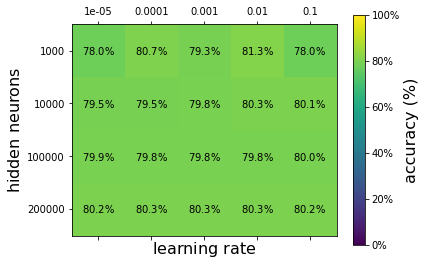

In [72]:
import argparse # handles arguments
import sys; sys.argv=['']; del sys # required to use parser in jupyter notebooks

# Training settings
parser = argparse.ArgumentParser(description='PyTorch SUSY Example')
parser.add_argument('--dataset_size', type=int, default=100000, metavar='DS',
                help='size of data set (default: 100000)')
parser.add_argument('--high_level_feats', type=bool, default=None, metavar='HLF',
                help='toggles high level features (default: None)')
parser.add_argument('--batch-size', type=int, default=100, metavar='N',
                help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.05, metavar='LR',
                help='learning rate (default: 0.02)')
parser.add_argument('--momentum', type=float, default=0.8, metavar='M',
                help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                help='disables CUDA training')
parser.add_argument('--seed', type=int, default=2, metavar='S',
                help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                help='how many batches to wait before logging training status')
args = parser.parse_args()

# set seed of random number generator
torch.manual_seed(args.seed)

grid_search(args)
